### ✅ 1. 라이브러리 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import os
from collections import Counter
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### ✅ 2. 데이터 전처리

In [ ]:
# 1. 전체 train 데이터를 불러오고 split
full_df = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/Projects/NLP/DATASET/Training.xlsx")

# 사람+시스템 문장 합치기
full_texts = full_df[['사람문장1', '시스템문장1', '사람문장2', '시스템문장2', '사람문장3']].fillna('').agg(' '.join, axis=1).tolist()
full_labels = full_df['감정_대분류'].tolist()

# train/val 분할 (예: 80% train, 20% val)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    full_texts, full_labels, test_size=0.2, random_state=42
)

# 2. 기존 Validation.xlsx → Test 데이터로 사용
test_df = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/Projects/NLP/DATASET/Test.xlsx")
test_texts = test_df[['사람문장1', '시스템문장1', '사람문장2', '시스템문장2', '사람문장3']].fillna('').agg(' '.join, axis=1).tolist()
test_labels = test_df['감정_대분류'].tolist()

# 3. 레이블 인코딩 (train 기준으로 fit)
le = LabelEncoder()
train_encoded_labels = le.fit_transform(train_labels)
val_encoded_labels = le.transform(val_labels)
test_encoded_labels = le.transform(test_labels)

num_classes = len(le.classes_)

# 4. vocab 생성 (train 기준으로만)
counter = Counter()
for text in train_texts:
    counter.update(text.split())

vocab = {"<pad>": 0, "<unk>": 1}
for idx, (word, _) in enumerate(counter.items(), start=2):
    vocab[word] = idx
vocab_size = len(vocab)

# 5. 인덱스 변환
def encode_text(text, max_len=120):
    tokens = [vocab.get(token, vocab["<unk>"]) for token in text.split()]
    return tokens[:max_len] + [vocab["<pad>"]] * (max_len - len(tokens))

X_train = [encode_text(t) for t in train_texts]
X_val = [encode_text(t) for t in val_texts]
X_test = [encode_text(t) for t in test_texts]

### ✅ 3. Dataset & DataLoader

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype=torch.long)
        self.y = torch.tensor(np.array(y), dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EmotionDataset(X_train, train_encoded_labels)
val_dataset = EmotionDataset(X_val, val_encoded_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


### ✅ 4. 모델 정의

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(CNN_BiLSTM_Attention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout_embed = nn.Dropout(0.3)

        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout_cnn = nn.Dropout(0.5)

        self.lstm = nn.LSTM(input_size=256, hidden_size=hidden_dim, bidirectional=True, batch_first=True)
        self.dropout_lstm = nn.Dropout(0.5)

        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout_attn = nn.Dropout(0.5)

        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout_fc = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout_embed(x)
        x = x.permute(0, 2, 1)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout_cnn(x)
        x = x.permute(0, 2, 1)

        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout_lstm(lstm_out)

        weights = torch.softmax(torch.tanh(self.attention(lstm_out)), dim=1)
        weights = self.dropout_attn(weights)

        context = torch.sum(weights * lstm_out, dim=1)
        context = self.dropout_fc(context)

        return self.fc(context)


### ✅ 5. 학습

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN_BiLSTM_Attention(
    vocab_size=vocab_size,
    embed_dim=200,              # ✅ 임베딩 차원 증가
    hidden_dim=256,             # ✅ LSTM 표현력 증가
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

patience = 5
no_improve_epochs = 0
best_loss = float('inf')
num_epochs = 30  # ✅ 더 많은 에폭 허용

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}")
    for X_batch, y_batch in loop:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []

    val_loop = tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}")
    with torch.no_grad():
        for X_batch, y_batch in val_loop:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    scheduler.step(avg_val_loss)

    print(f"✅ Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.4f}")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        save_path = "/content/drive/MyDrive/Colab_Notebooks/Projects/NLP/models/best_model.pt"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'vocab': vocab,
            'label_encoder': le
        }, save_path)
        print("✅ Best model saved.")
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        print(f"⚠ No improvement for {no_improve_epochs} epoch(s)")

    if no_improve_epochs >= patience:
        print("🛑 Early stopping triggered.")
        break


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[Val] Epoch 1: 100%|██████████| 323/323 [00:01<00:00, 191.36it/s]


✅ Epoch 1: Train Loss=2.2775, Val Loss=1.9752, Val Acc=0.2429
✅ Best model saved.


[Val] Epoch 2: 100%|██████████| 323/323 [00:01<00:00, 202.18it/s]


✅ Epoch 2: Train Loss=1.9379, Val Loss=1.8196, Val Acc=0.3093
✅ Best model saved.


[Val] Epoch 3: 100%|██████████| 323/323 [00:01<00:00, 198.94it/s]


✅ Epoch 3: Train Loss=1.7310, Val Loss=1.6400, Val Acc=0.3906
✅ Best model saved.


[Val] Epoch 4: 100%|██████████| 323/323 [00:01<00:00, 203.44it/s]


✅ Epoch 4: Train Loss=1.5460, Val Loss=1.5257, Val Acc=0.4403
✅ Best model saved.


[Val] Epoch 5: 100%|██████████| 323/323 [00:01<00:00, 187.46it/s]


✅ Epoch 5: Train Loss=1.3745, Val Loss=1.3925, Val Acc=0.5097
✅ Best model saved.


[Val] Epoch 6: 100%|██████████| 323/323 [00:01<00:00, 200.24it/s]


✅ Epoch 6: Train Loss=1.1976, Val Loss=1.3176, Val Acc=0.5465
✅ Best model saved.


[Val] Epoch 7: 100%|██████████| 323/323 [00:01<00:00, 200.89it/s]


✅ Epoch 7: Train Loss=1.0790, Val Loss=1.3409, Val Acc=0.5376
⚠ No improvement for 1 epoch(s)


[Val] Epoch 8: 100%|██████████| 323/323 [00:01<00:00, 189.03it/s]


✅ Epoch 8: Train Loss=0.9741, Val Loss=1.3174, Val Acc=0.5543
✅ Best model saved.


[Val] Epoch 9: 100%|██████████| 323/323 [00:01<00:00, 198.84it/s]


✅ Epoch 9: Train Loss=0.8856, Val Loss=1.3452, Val Acc=0.5618
⚠ No improvement for 1 epoch(s)


[Val] Epoch 10: 100%|██████████| 323/323 [00:01<00:00, 201.86it/s]


✅ Epoch 10: Train Loss=0.8022, Val Loss=1.3587, Val Acc=0.5681
⚠ No improvement for 2 epoch(s)


[Val] Epoch 11: 100%|██████████| 323/323 [00:01<00:00, 193.66it/s]


✅ Epoch 11: Train Loss=0.7254, Val Loss=1.4614, Val Acc=0.5624
⚠ No improvement for 3 epoch(s)


[Val] Epoch 12: 100%|██████████| 323/323 [00:01<00:00, 202.49it/s]


✅ Epoch 12: Train Loss=0.6590, Val Loss=1.4611, Val Acc=0.5568
⚠ No improvement for 4 epoch(s)


[Val] Epoch 13: 100%|██████████| 323/323 [00:01<00:00, 202.13it/s]

✅ Epoch 13: Train Loss=0.5030, Val Loss=1.6189, Val Acc=0.5543
⚠ No improvement for 5 epoch(s)
🛑 Early stopping triggered.


In [ ]:
# ✅ Colab용 파일 업로드
from google.colab import files
# ✅ 모델 저장
torch.save(model.state_dict(), 'cnn_bilstm_attention.pt')
files.download('cnn_bilstm_attention.pt')  # 로컬로 다운로드

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### ✅ 6. 검증

📊 최종 Test 결과:
              precision    recall  f1-score   support

        가족관계       0.69      0.81      0.74       390
          건강       0.39      0.37      0.38       380
       건강,죽음       0.51      0.51      0.51       761
        대인관계       0.59      0.59      0.59      1363
대인관계(부부, 자녀)       0.52      0.68      0.59       452
    연애,결혼,출산       0.76      0.70      0.73       376
          재정       0.54      0.66      0.60       557
  재정,은퇴,노후준비       0.76      0.30      0.43       313
 직장, 업무 스트레스       0.50      0.50      0.50       433
    진로,취업,직장       0.57      0.59      0.58       569
    학교폭력/따돌림       0.87      0.78      0.82       551
     학업 및 진로       0.76      0.69      0.73       496

    accuracy                           0.60      6641
   macro avg       0.62      0.60      0.60      6641
weighted avg       0.61      0.60      0.60      6641



/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51313 (\N{HANGUL SYLLABLE JOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

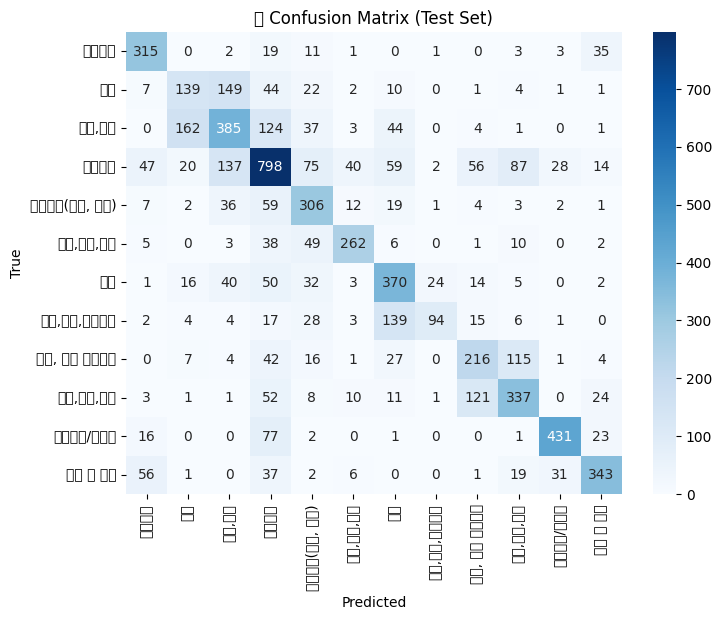

In [ ]:
# ✅ Best 모델 로드
checkpoint = torch.load("/content/drive/MyDrive/Colab_Notebooks/Projects/NLP/models/best_model.pt", weights_only=False )
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# ✅ 테스트셋 준비
test_dataset = EmotionDataset(X_test, test_encoded_labels)
test_loader = DataLoader(test_dataset, batch_size=32)

# ✅ 예측 수행
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# ✅ F1-score, precision, recall
print("📊 최종 Test 결과:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# ✅ Confusion Matrix 시각화
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("🧩 Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()